## ADA final exam (Fall 2022)

This exam consists of 3 tasks. Tasks 2 and 3 are independent of each other (although conceptually related).


## Dataset

For a Wikipedia editor to become an administrator, a so-called “request for adminship” ([RfA](https://en.wikipedia.org/wiki/Wikipedia:Requests_for_adminship)) must be submitted by either the candidate or another community member. Subsequently, any Wikipedia member may cast a supporting or opposing vote. Here we provide a simplified version of the Wikipedia RfA dataset, containing all votes from 2003 through 2012.

###  Data format

|        |   SRC |   TGT |   VOT |   RES |   YEA | DAT                 | TXT                                                                                                                                                                                               |
|-------:|------:|------:|------:|------:|------:|:--------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  39054 |  3444 | 10170 |     1 |     1 |  2009 | 2009-07-01 17:50:00 | '''Support''' - Best of luck. &nbsp;                                                                                                                                                              |
| 159680 |   722 |  9634 |    -1 |    -1 |  2006 | 2006-12-15 07:28:00 | '''Oppose''' Not even 2000 edits.                                                                                                                                                                 |
| 173438 |  4194 |  5524 |     1 |     1 |  2005 | 2005-03-18 19:22:00 | Ohhh, you're Carrp!  In that case, '''Support'''.                                                                                                                                                 |
|  60627 |  4855 |  9436 |     1 |     1 |  2008 | 2008-12-18 23:26:00 | '''Support''' via thoughtful answer to my question that demonstrates this editor has clue.                                                 |
| 194809 |  7687 |   908 |     1 |     1 |  2004 | 2004-09-25 05:21:00 | Nicholas is very good in English. Also, he got '''exceptional''' patience to explain petty obvious facts in talk page to convince ignorants. Let the world be benefitted more out of his work. -- |


- SRC: the user name of the source of the vote, i.e., of the user who cast the vote.
- TGT: the user name of the target of the vote, i.e., of the user running for election.
- VOT: the source's vote on the target (-1 = oppose; 1 = support).
- RES: the outcome of the election (-1 = target was rejected as admin; 1 = target was accepted). **(We will not use this  column in this exam.)**
- YEA: the year of the RfA.
- DAT: the date and time of this vote. **(We will not use this column in this exam.)**
- TXT: the comment written by the source. **(We will not use this column in this exam.)**

---


## Structural balance theory

**Structural balance theory** affirms that social networks tend to be organized so as to avoid conflictual situations, e.g., if a great friend of yours hates someone, you will likely not befriend that person.

The theory can be operationalized by looking at _triangles_ in an undirected _signed graph_ capturing person-to-person relationships, where a _signed graph_ is a  graph in which each edge is associated with a positive or negative sign, and a _triangle_ is a set of three edges ($\langle u,v \rangle$, $\langle v,w\rangle$, $\langle u,w\rangle$) that fully connect three distinct nodes ($u, v, w$).



_Triangles_ in an undirected signed graph can be in 4 _configurations_:
all positive edges ($\{+,+,+\}$); 
all negative edges ($\{-,-,-\}$); 
two positive edges and one negative edge ($\{+,+,-\}$);
one positive edge and two negative edges ($\{+,-,-\}$).

Structural balance theory posits that social networks tend to favor triangle configurations with an even number of negative signs (i.e., $\{+,+,+\}$ and $\{+,-,-\}$), which can be understood as being “balanced” by avoiding conflictual situations. Intuitively, $\{+,+,+\}$ could be tagged as “The friend of my friend is my friend”, and $\{+,-,-\}$ as “The enemy of my enemy is my friend”, “The friend of my enemy is my enemy”, or “The enemy of my friend is my enemy”. On the contrary, triangle configurations with an odd number of negative signs (i.e., $\{+,+,-\}$ and $\{-,-,-\}$) are unstable (“unbalanced”) according to structural balance theory and will thus occur less frequently in social networks. For instance, me being friends with two mutual enemies ($\{+,+,-\}$) would lead to tension that could be resolved if the two enemies became friends or if I took sides and ended my friendship with one of the two. Similarly, two among three mutual enemies ($\{-,-,-\}$) would have the incentive to form an alliance to “gang up” against the third.

Some social scientists have argued that three mutual enemies ($\{-,-,-\}$) is not necessarily a triangle configuration that social networks tend to avoid. This gives rise to **weak structural balance theory**, which only posits that social networks tend to avoid the “unbalanced” triangle configuration $\{+,+,-\}$.

In a nutshell,
- structural balance theory
  - considers $\{+,+,+\}$, $\{+,-,-\}$ as balanced,
  - and $\{+,+,-\}$, $\{-,-,-\}$ as unbalanced;
- weak structural balance theory
  - considers $\{+,+,+\}$, $\{+,-,-\}$, $\{-,-,-\}$ as balanced,
  - and $\{+,+,-\}$ as unbalanced.



In [1]:
import os
import gzip
import random
import pickle
import re
import itertools
import collections
import operator
import requests
from urllib.parse import *
from datetime import *
from dateutil.parser import parse

import math
import sklearn
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import *

import ast
import gensim
import string
import nltk
import codecs
import json
import vaderSentiment
import spacy
from empath import Empath
from bs4 import BeautifulSoup

import networkx as nx

from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

print("Package import test successful!")

Package import test successful!


### Task 1: Preliminaries

As a good data scientist, you first load the data and explore it.

**1.1**
Load the csv file `wiki-RfA.csv.gz` in a pandas dataframe. Calculate the number of distinct RfAs and the average number of votes per RfA.
- **Hint:** Throughout this question, assume that each RfA is uniquely determined by the column `TGT` and each vote is uniquely determined by the combination of `SRC` and `TGT`.

In [2]:
# 1.1
wiki = pd.read_csv('wiki-RfA.csv.gz')
wiki=wiki.drop(columns=['DAT', 'TXT'])
number_distinct_RfAs = len(wiki.groupby('TGT').SRC.sum())
average_votes = float(wiki.groupby('TGT').VOT.count().agg(['mean']))
print(f'There are {number_distinct_RfAs} distinct RfAs and an average number of {average_votes:.2f} votes per RfA.')

There are 3439 distinct RfAs and an average number of 48.56 votes per RfA.


**1.2** 
In a single figure with three subfigures (one per item), show the following time series:
- the number of RfAs per year;
- the overall fraction of positive votes per year; and 
- the average number of votes per RfA per year.

For each of the above three quantities, print the value for the year 2008.

In [3]:
total_per_year = wiki.groupby(['YEA']).VOT.count().reset_index()
frac_pos_per_year = wiki[wiki['VOT']==1].groupby(['YEA']).count().VOT.reset_index()
frac_pos_per_year['fraction_pos'] = frac_pos_per_year['VOT']/total_per_year['VOT']
frac_pos_per_year.drop(columns='VOT')

,YEA,fraction_pos
0,2003,0.984615
1,2004,0.874970
2,2005,0.860152
3,2006,0.773918
4,2007,0.798245
5,2008,0.761227
6,2009,0.747279
7,2010,0.751840
8,2011,0.794455
9,2012,0.722391


Number of RfAs in 2008:  26833
Fraction of positive votes in 2008: 0.7612268475384787
Average votes per RfA in 2008: 51.60192307692308


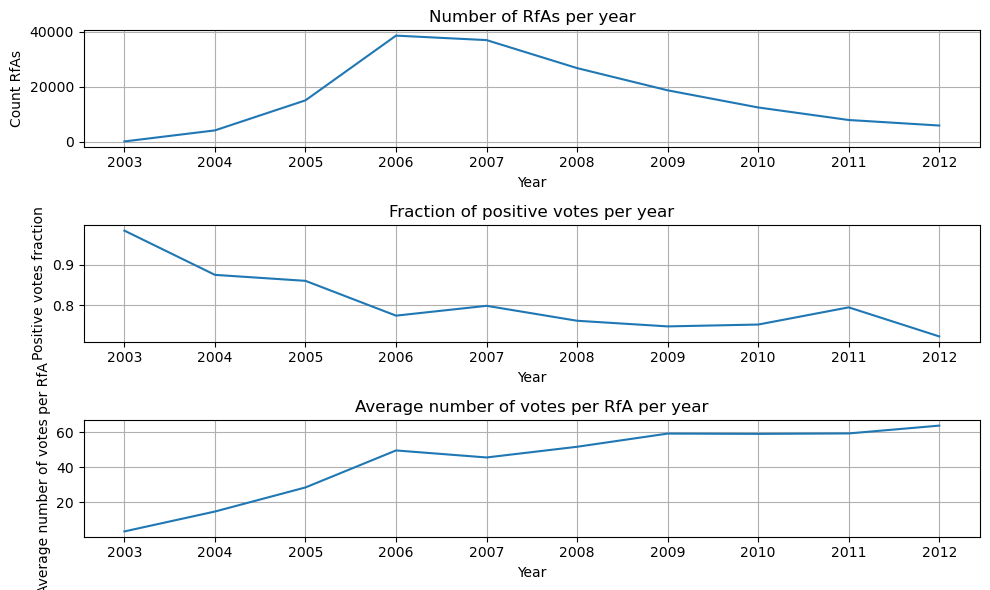

In [4]:
# 1.2 
count_RfAs_per_year = wiki.groupby(['YEA']).TGT.count().reset_index() #WHY?????????

total_per_year = wiki.groupby(['YEA']).VOT.count().reset_index()
frac_pos_per_year = wiki[wiki['VOT']==1].groupby(['YEA']).count().VOT.reset_index()
frac_pos_per_year['fraction_pos'] = frac_pos_per_year['VOT']/total_per_year['VOT']
frac_pos_per_year.drop(columns='VOT')

average_votes_per_year = wiki.groupby(['YEA','TGT']).SRC.count().reset_index()
average_votes_per_year = average_votes_per_year.groupby('YEA').SRC.mean().reset_index()

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)  # (rows, cols, index) => 2 rows, 1 column, 1st plot
plt.plot(count_RfAs_per_year['YEA'], count_RfAs_per_year['TGT'], label="Number of RfAs per year")  # Plot with red line
plt.title("Number of RfAs per year")  # Title of the subplot
plt.xlabel("Year")  # X-axis label
plt.xticks(count_RfAs_per_year['YEA'])
plt.ylabel("Count RfAs")  # Y-axis label
plt.grid(True)  # Add grid lines for better visualization

print('Number of RfAs in 2008: ',int(count_RfAs_per_year[count_RfAs_per_year.YEA == 2008].TGT))

# Second subplot
plt.subplot(3, 1, 2) 
plt.plot(frac_pos_per_year['YEA'], frac_pos_per_year['fraction_pos'], label="Fraction of positive votes per year")  # Plot with red line
plt.title("Fraction of positive votes per year")  # Title of the subplot
plt.xlabel("Year")  # X-axis label
plt.xticks(count_RfAs_per_year['YEA'])
plt.ylabel("Positive votes fraction")  # Y-axis label
plt.grid(True)  # Add grid lines for better visualization

print(f'Fraction of positive votes in 2008: {float(frac_pos_per_year[frac_pos_per_year.YEA == 2008].fraction_pos)}')

# Third subplot
plt.subplot(3, 1, 3)
plt.plot(average_votes_per_year['YEA'], average_votes_per_year['SRC'], label="Average number of votes per RfA per year")  # Plot with blue dashed line
plt.title("Average number of votes per RfA per year")  # Title of the subplot
plt.xlabel("Year")  # X-axis label
plt.xticks(average_votes_per_year['YEA'])
plt.ylabel("Average number of votes per RfA")  # Y-axis label
plt.grid(True)  # Add grid lines for better visualization

print(f'Average votes per RfA in 2008: {float(average_votes_per_year[average_votes_per_year.YEA == 2008].SRC)}')

# Adjust layout to avoid overlap between plots
plt.tight_layout()

# Show the final figure
plt.show()



**1.3** 
**/Discuss:/** Describe the temporal patterns observed in the plots you did in **T1.2**.

**A1.3** 
- increase in number of RfAs per year until 2006-2007 than a decrease
- fraction of positive votes per year decrease through years. seems fair since there is an increase of RfAs, so more users can vote and may be not prone to positively vote for an user
- the average votes per RfA per year is globally increasing across the years and seems to reach a limit around 2009 with an average number of votes around 60 per RfA.

So the plots shows an increase in number of votes with an increase in RfAs number.

**1.4** 
Create an undirected graph ([`nx.Graph`](https://networkx.org/documentation/stable/reference/classes/graph.html)) where every node corresponds to a Wikipedia user (source or target of an RfA) and where there exists an edge between two users if at least one of them has voted on the other. Each edge should have attributes corresponding to columns of the dataframe, namely:
- `VOT`, which equals `1` if the vote was positive, and `-1` otherwise.
- `YEA`, an integer that represents the year of the RfA.

**The code to load the graph has been provided to you!** After running it, print the number of nodes and edges in your graph.

---

**Observation:** Note that we have at most one edge per pair of nodes in the graph, even though two votes may be associated with the pair  — e.g., if A voted in B's RfA in time $t_1$ and B voted in A's RfA in time $t_2$ ($t_1 < t_2$). In these cases, the code provided associates the metadata of the oldest vote ($t_1$ in the example) to the edge between A and B.

In [5]:
# Provided code! Do not change!
import networkx as nx
import pandas as pd
G = nx.from_pandas_edgelist(pd.read_csv("./wiki-RfA.csv.gz"), 
                            'SRC', 'TGT', ['VOT', 'RES', 'YEA', 'DAT'], create_using=nx.Graph)

In [6]:
# 1.4
nx.info(G)

'Graph with 10831 nodes and 161147 edges'

**1.5** 
Plot the **complementary** cumulative distribution of the degree centrality of the undirected graph. Use a logarithmic (base 10) x-axis and a linear y-axis.

Text(0.5, 0, 'Degree centrality')

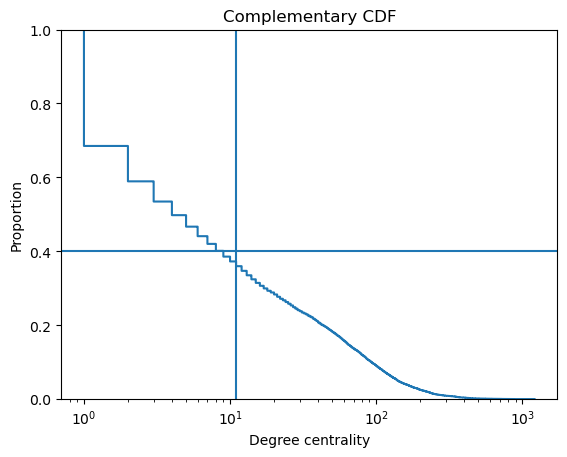

In [7]:
# 1.5
sns.ecdfplot(list(dict(G.degree()).values()), complementary=True)
plt.xscale("log")
plt.axvline(11)
plt.axhline(0.4)
plt.title("Complementary CDF")
plt.xlabel("Degree centrality")


**1.6**
**/Discuss:/** Why is the following statement false? Justify your answer. **"From the graph obtained in task 1.5, one can conclude that around 40% of the users voted at least 11 times."**


**A1.6**
False

Around 40% of the users had at least degree 11. 
However, the graph counts both receiving and casting a vote as an edge.
Thus, there can be users with degree 11 that cast LESS than 11 votes.
Therefore, 40% is an upper bound and the statement is false.

**1.7**
What fraction of users voted at least 11 times? Use the data to measure the fraction.

In [8]:
# 1.7
G_ = nx.from_pandas_edgelist(wiki, 'SRC', 'TGT', ['VOT', 'RES', 'YEA'], create_using=nx.MultiDiGraph)

tmp = sorted(dict(G_.out_degree()).values())

len([t for t in tmp if t >= 11]) / len(tmp)

# Obligé de faire un multigraph pcq on veut voir les relations in et out (ici out bc has voted)

0.24863816822084756

### Task 2: Triangles

Next, you set out to investigate the social balance theory by looking at the RfA graph.

**2.1**
Considering _only_ the RfAs of 2004 (i.e., where `YEA == 2004`), generate all triangles in the undirected graph.
Print the number of triangles found.
- **Hint:** Note that you can generate a graph with only a subset of nodes and edges via ` G.edge_subgraph`.
-  **Hint:** The function `nx.enumerate_all_cliques` generates all cliques in an undirected graph. First, all cliques of size 1 are generated, then all cliques of size 2, etc. Triangles are cliques of size 3.


In [9]:
# 2.1
# Get list of edges where the "YEA" attribute equals 2004
edges_2004 = [i for i, v in nx.get_edge_attributes(G, "YEA").items() if v == 2004]

# Create a subgraph containing only the edges from 2004 and their associated nodes
G_2004 = G.edge_subgraph(edges_2004)

# Initialize counters and storage for triangles
number_triangle = 0  # Counter for the number of triangles
tmp = []  # List to store the nodes forming each triangle

# Iterate through all cliques in the subgraph
for i in nx.enumerate_all_cliques(G_2004):
    if len(i) < 3:  # Ignore cliques with fewer than 3 nodes (not triangles)
        continue
    if len(i) > 3:  # Stop the loop if the clique size exceeds 3 (not triangles)
        break
    number_triangle += 1  # Increment triangle counter
    tmp.append(i)  # Store the triangle's nodes

# Output the total number of triangles found
print("Triangles", number_triangle)


Triangles 8448


**2.2 ** **/True or false:/** Is the following statement true or false? Justify your answer. **"The node with the highest clustering coefficient in an undirected graph is the node that belongs to the largest number of triangles."**

**A2.2** **False**. 

**Intuition:** cluster coefficient is a fraction of closed triangles in ego net. This says nothing about the absolute number of triangles in the ego network (i.e., the network of neighbors).

**Counter example:**
Consider the following counter-example in a graph with 5 nodes: $u_1$, $u_2$ $u_3$, $u_4$ and $u_5$, and 6 edges, 
$\langle u_1, u_2 \rangle$,
$\langle u_1, u_3 \rangle$,
$\langle u_2, u_3 \rangle$,
$\langle u_2, u_4 \rangle$,
$\langle u_2, u_5 \rangle$,
$\langle u_4, u_5 \rangle$.

```
1 ----- 3
 \     /
  \   /
    2
  /   \
 /     \
4 ----- 5

``` 


- $u_1$ has clustering coefficient equals 1, as the only neighbors of the node are connected. 
- $u_1$ belongs to 1 triangle.
- $u_2$ has clustering coefficient equals 1, because $u_4$ and $u_5$ are not connected.
- $u_2$ belongs to 2 triangles.

**2.3** Considering the set of triangles previously calculated, estimate the fraction of triangles of configurations
 $\{+,+,+\}$,  $\{-,-,-\}$,  $\{+,+,-\}$, and $\{+,-,-\}$. What fraction of triangles are "balanced" according to structural balance theory?

In [10]:
# 2.3

counter = { # create a dict 
    (-1, -1, -1): 0, # -3
    (-1, -1, 1):  0,  # +1-2
    (-1, 1, 1):   0,   # +2-1
    (1, 1, 1):    0     # +3
}


for tmp_ in tmp:
    x = nx.get_edge_attributes(G.subgraph(tmp_), "VOT")
    x = tuple(sorted([sign for (u, v), sign in x.items()]))
    counter[x] += 1

# normalizes it
for k in counter:
    counter[k] /= len(tmp)

print("{-,-,-}:", 
      round(counter[(-1, -1, -1)], 4) 
)
print("{+,-,-}:", 
      round(counter[(-1, -1, 1)], 4) 
)
print("{+,+,-}:", 
      round(counter[(-1, 1, 1)], 4) 
)
print("{+,+,+}:", 
      round(counter[(1, 1, 1)], 4) 
)

print("Balanced:", round(counter[(-1, -1, 1)] + counter[(1, 1, 1)], 4) )

{-,-,-}: 0.0052
{+,-,-}: 0.0627
{+,+,-}: 0.1394
{+,+,+}: 0.7926
Balanced: 0.8554


**2.4** To observe how triangle configurations would be distributed under a random null model, do the following:
- Create a new column `VOT_RND` in the dataframe, where RfA votes (i.e., edge signs in the graph) are shuffled, i.e., permuted randomly.  For shuffling, use `numpy.random`, without replacement and with the seed 32 (see code provided below).
- Create a new edge attribute with the values of `VOT_RND` in the graph you created in task **1.4**. You can do this easily using the  [`set_edge_attributes`](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.set_edge_attributes.html) function.
- Considering the shuffled edge signs,  compute the fraction of triangles in each configuration ($\{+,+,+\}$,  $\{-,-,-\}$,  $\{+,+,-\}$, $\{+,-,-\}$). Moreover, compute the fraction of triangles that are "balanced" according to structural balance theory. (Reminder: consider only the RfAs of 2004.)


In [11]:
# PROVIDED STUB FOR 2.4
import numpy as np
np.random.seed(32)
df_2004 = wiki[wiki.YEA == 2004].copy(deep=True)
df_2004["VOT_RND"] = np.random.choice(df_2004["VOT"].values, size=len(df_2004), replace=False)

In [12]:
# 2.4

import numpy as np

# Step 1: Create a dictionary of edge attributes from the DataFrame df_2004
# The dictionary maps edge pairs (SRC, TGT) to their "VOT_RND" value
attrs_to_add = dict(df_2004.set_index(["SRC", "TGT"]).VOT_RND)

# Step 2: Add the "VOT_RND" attribute to the edges of the graph G
nx.set_edge_attributes(G, name="VOT_RND", values=attrs_to_add)

# Step 3: Initialize a counter to track specific patterns of "VOT_RND" values in triangles
counter2 = {
    (-1, -1, -1): 0,  # All edges in the triangle have "VOT_RND" = -1
    (-1, -1, 1):  0,  # Two edges have "VOT_RND" = -1, one edge has "VOT_RND" = 1
    (-1, 1, 1):   0,  # One edge has "VOT_RND" = -1, two edges have "VOT_RND" = 1
    (1, 1, 1):    0   # All edges in the triangle have "VOT_RND" = 1
}

# Step 4: Analyze each triangle (stored in the list `tmp`)
for tmp_ in tmp:
    # Extract the "VOT_RND" attributes for all edges in the triangle (subgraph of G)
    x = nx.get_edge_attributes(G.subgraph(tmp_), "VOT_RND")
    
    # Convert the edge attributes into a sorted tuple of signs (e.g., (-1, -1, 1))
    x = tuple(sorted([sign for (u, v), sign in x.items()]))
    
    # Increment the corresponding pattern in the counter
    counter2[x] += 1

# Step 5: Normalize the counts in `counter2` by dividing by the total number of triangles
for k in counter2:
    counter2[k] /= len(tmp) 

# Step 6: Print the results for each pattern
print("{-,-,-}:",
      round(counter[(-1, -1, -1)], 4), "/ Null: ",
      round(counter2[(-1, -1, -1)], 4),
)
print("{+,-,-}:",
      round(counter[(-1, -1, 1)], 4), "/ Null: ",
      round(counter2[(-1, -1, 1)], 4)
)
print("{+,+,-}:",
      round(counter[(-1, 1, 1)], 4), "/ Null: ",
      round(counter2[(-1, 1, 1)], 4)
)
print("{+,+,+}:",
      round(counter[(1, 1, 1)], 4), "/ Null: ",
      round(counter2[(1, 1, 1)], 4)
)

# Step 7: Compute the proportion of balanced triangles
# "Balanced" is defined as triangles where edges have a mix of +1 and -1
"Balanced, ", round(counter2[(-1, -1, 1)] + counter2[(1, 1, 1)], 4)


{-,-,-}: 0.0052 / Null:  0.0019
{+,-,-}: 0.0627 / Null:  0.0344
{+,+,-}: 0.1394 / Null:  0.2779
{+,+,+}: 0.7926 / Null:  0.6857


('Balanced, ', 0.7202)

**2.5** **/Discuss:/** Do the results of tasks **2.3** and **2.4** suggest that structural balance theory is correct? What kind of subsequent analysis would make you trust that the results are not obtained simply by chance? (No need to actually perform that subsequent analysis here.) Justify your answer.

**A2.5** The fraction of balanced triangles of the original (real) graph is higher than that of the random shuffled (null) graph, which suggests that Structural Balance Theory is correct, since balanced patterns are more frequently observed than random. To show the results are not obtained simply by chance, one could use bootstrap to obtain confidence intervals.

### Interlude: Additional data

In the data provided in the file `wiki-RfA.csv.gz` (with which you’ve worked up to now), each column corresponds to a vote from a user $u$ to a user $v$ at a time $t$. 

In **Task 2**, we did not consider the temporal aspect of this network. For the next task, you are provided with a complimentary dataset (`data/wiki-RfA_extra.csv.gz`) containing, for each vote (uniquely determined by `SRC` and `TGT`), a variety of features. **Importantly, these features were calculated considering only data that was already available at the time when the respective vote was cast.** The features are described as follows.

- `PP`, `NN`, `PN` — Each vote (signed edge) is part of zero or more triangles, and we computed the number of triangles in which the two remaining edges were both positive (`PP`), both negative (`NN`) and of different signs (i.e., one positive and one negative, `PN`). This considers only the votes the target (denoted by `TGT`) has received before the current vote. 

- `P`, `N` — The number of positive (`P`) and negative (`N`) votes that the target `TGT` received before the current vote.

- `TXT_PROCESSED` — The text in the original dataset, processed so 1) it is entirely lower-case, 2) it does not contain non-alphanumeric characters, and 3) it does not contain words starting with “supp” or “opp” (since words such as "support" and "oppose"  are obvious give-away signals of the vote).

### Interlude: Predicting edge signs with structural balance theory

We can use structural balance theory to predict edge signs. 

Consider an edge whose sign we do not know, as well as the fractions `PP`, `NN`, and `PN` associated with the edge, as defined above. 

According to structural balance theory, if `PP` + `NN` $\geq$ `PN`, the vote is predicted to be positive, as this will create more balanced triangles in the graph. Otherwise, it is predicted to be negative. 

According to the weak structural balance theory, if `PP` $\geq$ `PN`, the vote is predicted to be positive, as this will create more balanced triangles in the graph. Otherwise, it is predicted to be negative. 

Note that in both cases we use “$\geq$” rather than “<”, i.e., when both sides of the equation are equal, we break ties in favor of positive edges. We do so because there are more positive edges in the graph.

### Task 3: Predict it!

In the final part of the exam, you will leverage your machine learning and regression skills.

**3.1** Merge the new dataset with the original dataframe from task **1** using the columns `SRC` and `TGT`. You may drop the old `TXT` column if you want to. 


In [13]:
# 3.1
wiki_extra = pd.read_csv('wiki-RfA_extra.csv.gz')
wiki_final = pd.merge(
    left=wiki, 
    right=wiki_extra,
    how='left',
    on=['SRC', 'TGT','YEA'],
)
wiki_final


,SRC,TGT,VOT,RES,YEA,PP,NN,PN,N,P,TXT_PROCESSED
0,5943,9966,-1,-1,2012,2,0,4,12,0,
1,9153,9966,-1,-1,2012,2,1,3,11,0,this joke really isn t funny not even if you ...
2,4189,9966,-1,-1,2012,0,0,2,10,0,as per nomination and answers
3,3750,9966,-1,-1,2012,0,0,0,9,0,and speeedy close this as wp snow as it s cle...
4,4225,9966,-1,-1,2012,0,0,1,8,0,per nomination and answers i am particularly ...
...,...,...,...,...,...,...,...,...,...,...,...
166998,3867,2762,1,1,2003,0,0,0,0,0,also llywrch has been here for ages and done n...
166999,8091,8486,1,1,2003,0,0,0,0,0,user talk fantasy thanks and other of his act...
167000,1581,8767,1,1,2003,0,0,0,0,0,for wikiquote but i haven t seen enough evide...
167001,1011,8056,1,1,2003,0,0,0,0,0,does good things with maps


**3.2**  Create the following two rule-based classifiers, and for each, estimate its area under the ROC curve (a.k.a. “AUC/ROC”) on the entire dataset:

- **A)** a classifier inspired by structural balance theory. The classifier should predict a positive vote if  `PP` + `NN` $\geq$ `PN`, and a negative vote otherwise.
- **B)** a classifier inspired by weak structural balance theory. The classifier should predict a positive vote if `PP`  $\geq$ `PN` and a negative vote otherwise.

In [14]:
# 3.2
from sklearn import metrics
import sklearn.metrics

#A)
y = (wiki_final.VOT == 1).astype(int)
y_pred = (wiki_final.PP + wiki_final.NN >= wiki_final.PN).astype(int)
print('Structural balance theory AUC/ROC score: ',sklearn.metrics.roc_auc_score(y, y_pred))

#A)
y = (wiki_final.VOT == 1).astype(int)
y_pred = (wiki_final.PP >= wiki_final.PN).astype(int)
print('Weak structural balance theory AUC/ROC score: ',sklearn.metrics.roc_auc_score(y, y_pred))


Structural balance theory AUC/ROC score:  0.525390127858417
Weak structural balance theory AUC/ROC score:  0.528036104766419


**3.3** To determine if the differences in the classifiers from task **3.2** occur solely due to chance, follow the following bootstrap procedure, using 200 iterations:

- **A)** Randomly sample the entire dataset (i.e., votes from the dataframe constructed in task **3.1**) with replacement;
- **B)** Compute the difference of the AUC/ROC for the two classifiers on the entire dataset.

Then use the distribution of AUC/ROC differences (one difference per bootstrap iteration) to estimate the 95% confidence interval for the AUC/ROC difference.

In [18]:
# 3.3 

BF = []

for i in range(200):
    df_sample = wiki_final.sample(frac=1, replace=True)
    # A)
    y = (df_sample.VOT == 1).astype(int)
    y_pred = (df_sample.PP + df_sample.NN >= df_sample.PN).astype(int)
    
    BF1 = sklearn.metrics.roc_auc_score(y, y_pred)

    # B)
    y = (df_sample.VOT == 1).astype(int)
    y_pred = (df_sample.PP >= df_sample.PN).astype(int)
    BF2 = sklearn.metrics.roc_auc_score(y, y_pred)
    
    BF.append(BF1 - BF2)

print("95% CI:", np.quantile( np.array(BF), q=[0.025, 0.975]))

95% CI: [-0.00307234 -0.00223455]


**3.4 ** **/Discuss:**/ According to the results in tasks **3.2** and **3.3**, which theory better predicts actual edge signs, structural balance theory or the weak structural balance theory? 


**A3.4** The weak social balance theory makes the better predictions, since its AUC ROC score is significantly (according to the bootstrapped CIs) higher.



**3.5** How accurately can we predict the vote with more sophisticated features and algorithms?

- Create a TF-IDF representation of the text of each vote  using `sklearn`'s vectorizer ([`sklearn.feature_extraction.text.TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) with the parameters `max_features=150` and `stop_words='english'`.
- Split the  dataset into training and test sets using sklearn [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) using parameters `test_size=0.1` and  `random_state=42`.

- Then, train two logistic regression models ([`sklearn.linear_model.SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)) using parameters `loss='log_loss'` and `max_iter=2000` considering:

    - **1)** the TF-IDF feature vector

    - **2)** the TF-IDF feature vector and the features `PP`, `NN`, `PN`, `P`, and `N` related to the graph.

- Last, report the AUC/ROC of each model in the test set.

In [39]:
# 3.5
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.model_selection
from sklearn.linear_model import SGDClassifier

wiki_final.TXT_PROCESSED = wiki_final['TXT_PROCESSED'].fillna('')

# 1) the TF-IDF feature vector
vectorizer = TfidfVectorizer(max_features=150, stop_words="english")
classifier = SGDClassifier(loss='log_loss', max_iter=2000, random_state=0)

y =  (wiki_final.VOT == 1).values.astype(int)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(wiki_final.TXT_PROCESSED.values, 
                                                                            y, 
                                                                            test_size=0.1, random_state=42 )

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print('TF-IDF and SGD classifier: ',sklearn.metrics.roc_auc_score(y_test, y_pred))

X2_train, X2_test, _ , _ = sklearn.model_selection.train_test_split(wiki_final[["PP", "NN", "PN", "N", "P"]].values, 
                                                                            y, 
                                                                            test_size=0.1, random_state=42 )
X_train = np.hstack((X_train,X2_train))
X_test = np.hstack((X_test,X2_test))
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print('TF-IDF and SGD classifier (with other features): ',sklearn.metrics.roc_auc_score(y_test, y_pred))


TF-IDF and SGD classifier:  0.6990490909056859
TF-IDF and SGD classifier (with other features):  0.7415174260157225


**3.6** **/Discuss:**/  According to the results in task **3.5**, does information from the graph help in the task of predicting the vote even when using the text?  What kind of subsequent analysis would make you trust that the results are not obtained simply by chance? (No need to actually perform that subsequent analysis here.) 

**A3.6** Yes, because we get an increase in the performance of the model. To obtain confidence intervals we could bootstrap the difference between the classifier with and without the extra information from the graph.

**3.7** Putting on your observational studies hat, run two logistic regressions using `statsmodels`.
- In the first regression, the vote is the outcome, and `PP`, `NN` and `PN` are the predictors.
- In the second regression, the vote is the outcome, and `PP`, `NN`, `PN`, and `N` are the predictors.

In [47]:
# 3.7
import statsmodels.api as sm 

# 1st regression 
wiki_final['VOT2'] = (wiki_final.VOT ==1).values.astype(int)
display(smf.logit("VOT2 ~ PP + NN + PN" , data=wiki_final).fit().summary())
display(smf.logit("VOT2 ~ PP + NN + PN + N" , data=wiki_final).fit().summary())


Optimization terminated successfully.
         Current function value: 0.514594
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   VOT2   No. Observations:               167003
Model:                          Logit   Df Residuals:                   166999
Method:                           MLE   Df Model:                            3
Date:                Tue, 07 Jan 2025   Pseudo R-squ.:                 0.01804
Time:                        22:49:10   Log-Likelihood:                -85939.
converged:                       True   LL-Null:                       -87517.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2781      0.006    206.255      0.000       1.266       1.290
PP             0.2493      0.007     34.272      0.000       0.235       0.264
NN            -0.6765      0.040    -16.946      0.000      -0.755      -0.598
PN            -0.5509      0.014    -40.304      0.000      -0.578      -0.524
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.487994
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   VOT2   No. Observations:               167003
Model:                          Logit   Df Residuals:                   166998
Method:                           MLE   Df Model:                            4
Date:                Tue, 07 Jan 2025   Pseudo R-squ.:                 0.06880
Time:                        22:49:11   Log-Likelihood:                -81496.
converged:                       True   LL-Null:                       -87517.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6227      0.008    212.945      0.000       1.608       1.638
PP             0.2535      0.008     33.344      0.000       0.239       0.268
NN            -0.5466      0.040    -13.631      0.000      -0.625      -0.468
PN            -0.4561      0.014    -33.013      0.000      -0.483      -0.429
N             -0.0438      0.000    -89.263      0.000      -0.045      -0.043
==============================================================================
"""

**3.8** **/Discuss:**/   Explain what the coefficient associated with `PP` means in the first regression. Is it in accordance with structural balance theory?

**A3.8** Having two other positive edges in the triangle increase the log odds of a positive edge by around 0.25. This is in accordance with the balance theory; the friend of a friend is a friend.

**3.9** **/Discuss:**/   Compare the coefficients associated with `PN` and `NN` in the first vs. the second regression. Present a reason that may explain this difference.

**A3.9** 
The coefficients associated with `PN` and `NN` increase if you account for the number of negative votes previously received (`N`).

A possible explanation:
- Previous negative votes tell something about the quality of the candidate, decreasing the log odds that they receive positive votes (this can be seen in the second regression).
- When we do not control directly for previous negative votes, the coefficients `NN` and `PN` partially capture previous negative votes.

---